# Regressão Softmax com dados do MNIST

## Objetivo

O objetivo deste notebook é ilustrar o uso de praticamente a mesma rede desenvolvida para a classificação das flores Íris, porém agora com o problema de classificação de dígitos manuscritos utilizando o dataset MNIST.
As principais diferenças são:
- tipo do dado, agora imagem com muito atributos: 28 x 28 pixels
- número de amostras, muito maior, 60 mil
Neste exercício será possível a interpretação do significado dos parâmetros treinados

## Importação das bibliotecas

In [1]:
# http://pytorch.org/
from os.path import exists
#!pip install numpy==1.15.0
!pip install -q install wheel==0.34.2 setuptools

from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
print(get_abbr_impl())
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

#https://download.pytorch.org/whl/cpu/torch-0.4.1.post2-cp37-cp37m-linux_x86_64.whl
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1.post2-{platform}-linux_x86_64.whl torchvision
import torch

ERROR: tensorflow 2.5.0 has requirement wheel~=0.35, but you'll have wheel 0.34.2 which is incompatible.
cp
     |████████████████████████████████| 89.4MB 1.3MB/s 
ERROR: torchvision 0.10.0+cu102 has requirement torch==1.9.0, but you'll have torch 0.4.1.post2 which is incompatible.
ERROR: torchtext 0.10.0 has requirement torch==1.9.0, but you'll have torch 0.4.1.post2 which is incompatible.
ERROR: fastai 1.0.61 has requirement torch>=1.0.0, but you'll have torch 0.4.1.post2 which is incompatible.


In [5]:
! pip install torchvision==0.2.1

     |████████████████████████████████| 61kB 3.5MB/s 
ERROR: fastai 1.0.61 has requirement torch>=1.0.0, but you'll have torch 0.4.1.post2 which is incompatible.
  Found existing installation: torchvision 0.10.0+cu102
    Uninstalling torchvision-0.10.0+cu102:
      Successfully uninstalled torchvision-0.10.0+cu102


In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable

import torchvision

## Carregamento dos dados do MNIST

In [7]:
! git clone https://github.com/vcasadei/MNIST.git

Cloning into 'MNIST'...
remote: Enumerating objects: 10, done.
remote: Total 10 (delta 0), reused 0 (delta 0), pack-reused 10
Unpacking objects: 100% (10/10), done.


In [8]:
!ls MNIST

processed  raw


In [9]:
dataset_dir = 'MNIST/'

x_train, y_train = torch.load(dataset_dir + 'processed/training.pt')

print("Amostras de treinamento:", x_train.size(0))

print("\nDimensões dos dados das imagens:   ", x_train.size())
print("Valores mínimo e máximo dos pixels:", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:        ", type(x_train))
print("Tipo das classes das imagens:      ", type(y_train))

Amostras de treinamento: 60000

Dimensões dos dados das imagens:    torch.Size([60000, 28, 28])
Valores mínimo e máximo dos pixels: tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
Tipo dos dados das imagens:         <class 'torch.Tensor'>
Tipo das classes das imagens:       <class 'torch.Tensor'>


### Carregamento, normalização e seleção dos dados do MNIST

Neste exemplo utilizaremos apenas 1000 amostras de treinamento.

In [10]:
x_train = x_train.float()

x_train = x_train / 255.

if True:
    n_samples_train = 1000

    x_train = x_train[:n_samples_train]
    y_train = y_train[:n_samples_train]

print("Amostras de treinamento:", x_train.size(0))

print("\nDimensões dos dados das imagens:   ", x_train.size())
print("Valores mínimo e máximo dos pixels:", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:        ", type(x_train))
print("Tipo das classes das imagens:      ", type(y_train))

Amostras de treinamento: 1000

Dimensões dos dados das imagens:    torch.Size([1000, 28, 28])
Valores mínimo e máximo dos pixels: tensor(0.) tensor(1.)
Tipo dos dados das imagens:         <class 'torch.Tensor'>
Tipo das classes das imagens:       <class 'torch.Tensor'>


### Visualizando os dados

(-0.5, 232.5, 87.5, -0.5)

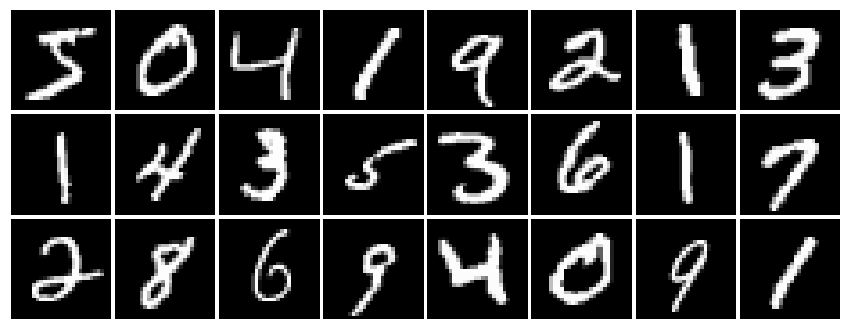

In [11]:
n_samples = 24

# cria um grid com as imagens
grid = torchvision.utils.make_grid(x_train[:n_samples].unsqueeze(dim=1), pad_value=1.0, padding=1)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off')

### Visualizando uma imagem com o matplotlib

class: tensor(5)


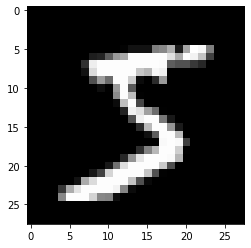

In [12]:
image  = x_train[0]
target = y_train[0]

plt.imshow(image.numpy(), cmap='gray')
print('class:', target)

## Modelo

In [14]:
model = torch.nn.Linear(28*28, 10) # 28*28 atributos de entrada e 10 neurônios na sáida

### Testando um predict com poucas amostras

In [15]:
xin = x_train[:5].view(-1,28*28)
score = model(Variable(xin))
score

tensor([[ 0.2701,  0.3262,  0.1213,  0.0617, -0.1525,  0.0034, -0.0927,  0.2354,
          0.0094, -0.2531],
        [-0.0514, -0.1922, -0.1056,  0.1993,  0.0645,  0.0793,  0.1390,  0.3739,
         -0.0042, -0.3665],
        [ 0.1037, -0.1051, -0.1962,  0.1286, -0.1682, -0.1125,  0.0860,  0.1966,
         -0.1468, -0.2309],
        [ 0.1846, -0.1175,  0.2389,  0.0519, -0.1108, -0.1438,  0.0220, -0.0371,
         -0.0247, -0.1842],
        [ 0.4231, -0.2521,  0.2239,  0.2351,  0.0624,  0.0715,  0.0815,  0.0470,
         -0.2410, -0.0801]], grad_fn=<ThAddmmBackward>)

## Treinamento

### Inicialização dos parâmetros

In [16]:
epochs = 100
learningRate = 0.5

# Utilizaremos CrossEntropyLoss como função de perda
criterion = torch.nn.CrossEntropyLoss()

# Gradiente descendente
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

### Visualização do grafo computacional da perda (loss)

In [17]:
!pip install graphviz
!pip install git+https://github.com/szagoruyko/pytorchviz

  Cloning https://github.com/szagoruyko/pytorchviz to /tmp/pip-req-build-325aodh1
  Running command git clone -q https://github.com/szagoruyko/pytorchviz /tmp/pip-req-build-325aodh1
  Created wheel for torchviz: filename=torchviz-0.0.2-cp37-none-any.whl size=4993 sha256=93d2fcb2cf9d3a378921023d7d19460defff57a6ad869b1b11c0dfd57bfb9d00
  Stored in directory: /tmp/pip-ephem-wheel-cache-0gzunrdh/wheels/b9/b9/85/ef34936f58754cb23840fd869be1367b5d525e29915a2a4fe9
Successfully built torchviz


In [19]:
from torchviz import make_dot, make_dot_from_trace
y_pred = model(Variable(x_train.view(-1,28*28)))
loss = criterion(y_pred, Variable(y_train))
loss
# p = make_dot(loss, dict(model.named_parameters()))
# p

tensor(2.2989, grad_fn=<NllLossBackward>)

### Laço de treinamento dos pesos

Epoch[1/100], loss: 2.298904, acc: 0.079000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


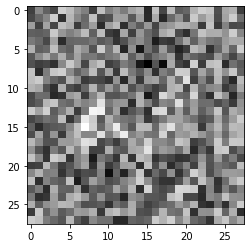

Epoch[2/100], loss: 1.791778, acc: 0.718000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


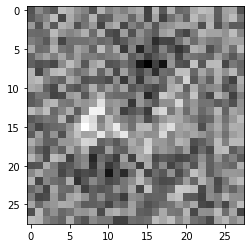

Epoch[3/100], loss: 1.457092, acc: 0.736000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


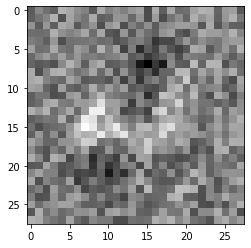

Epoch[4/100], loss: 1.238443, acc: 0.798000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


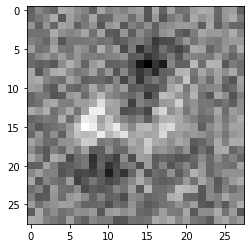

Epoch[5/100], loss: 1.090311, acc: 0.797000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


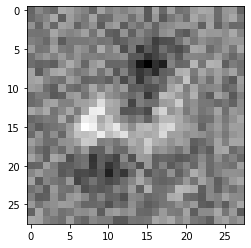

Epoch[6/100], loss: 0.984322, acc: 0.819000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


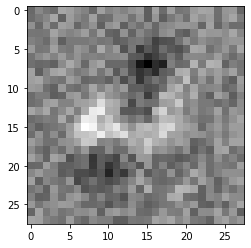

Epoch[7/100], loss: 0.904988, acc: 0.825000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


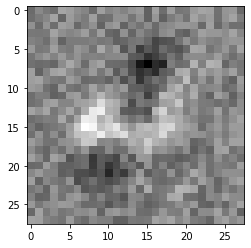

Epoch[8/100], loss: 0.843216, acc: 0.839000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


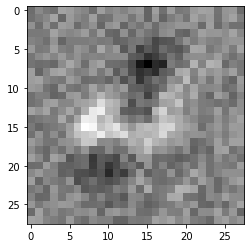

Epoch[9/100], loss: 0.793548, acc: 0.846000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


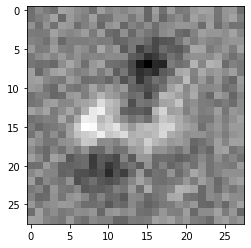

Epoch[10/100], loss: 0.752558, acc: 0.853000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


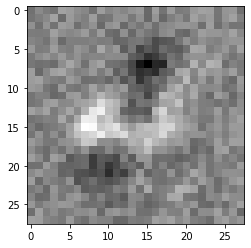

Epoch[11/100], loss: 0.718009, acc: 0.858000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


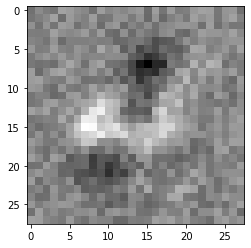

Epoch[12/100], loss: 0.688385, acc: 0.867000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


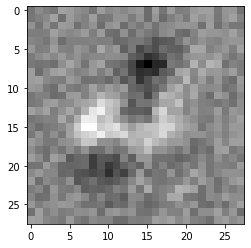

Epoch[13/100], loss: 0.662621, acc: 0.870000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


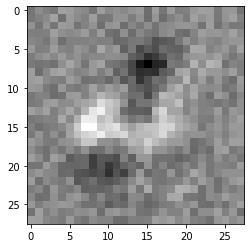

Epoch[14/100], loss: 0.639940, acc: 0.870000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


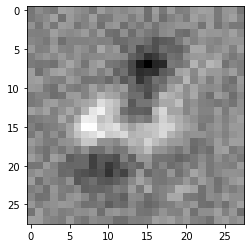

Epoch[15/100], loss: 0.619769, acc: 0.873000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


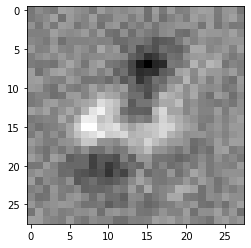

Epoch[16/100], loss: 0.601670, acc: 0.878000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


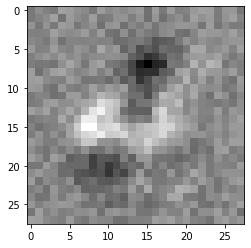

Epoch[17/100], loss: 0.585305, acc: 0.879000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


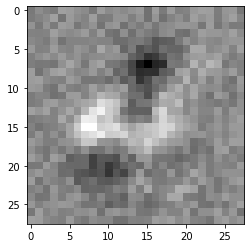

Epoch[18/100], loss: 0.570407, acc: 0.880000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


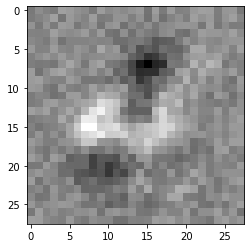

Epoch[19/100], loss: 0.556765, acc: 0.880000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


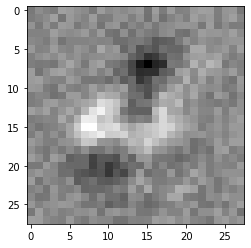

Epoch[20/100], loss: 0.544206, acc: 0.880000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


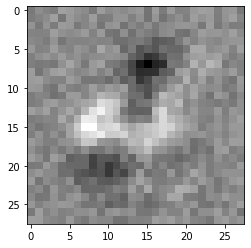

Epoch[21/100], loss: 0.532589, acc: 0.883000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


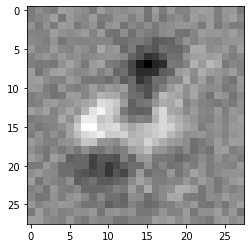

Epoch[22/100], loss: 0.521797, acc: 0.885000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


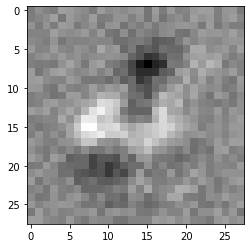

Epoch[23/100], loss: 0.511733, acc: 0.888000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


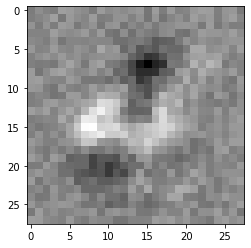

Epoch[24/100], loss: 0.502315, acc: 0.889000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


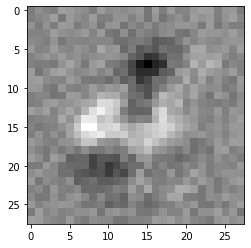

Epoch[25/100], loss: 0.493473, acc: 0.890000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


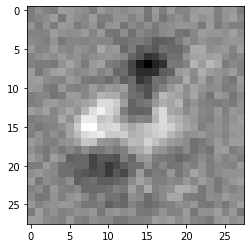

Epoch[26/100], loss: 0.485148, acc: 0.892000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


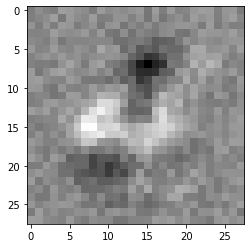

Epoch[27/100], loss: 0.477289, acc: 0.893000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


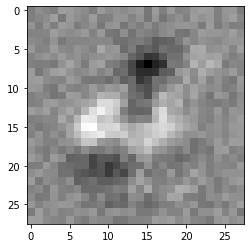

Epoch[28/100], loss: 0.469852, acc: 0.894000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


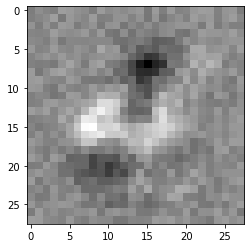

Epoch[29/100], loss: 0.462796, acc: 0.897000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


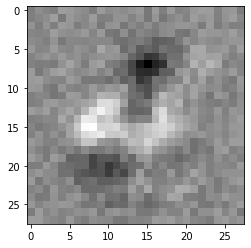

Epoch[30/100], loss: 0.456089, acc: 0.899000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


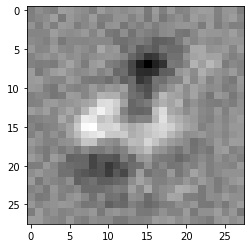

Epoch[31/100], loss: 0.449702, acc: 0.902000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


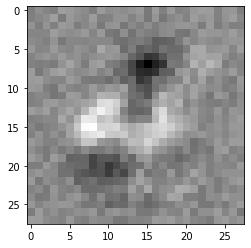

Epoch[32/100], loss: 0.443606, acc: 0.905000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


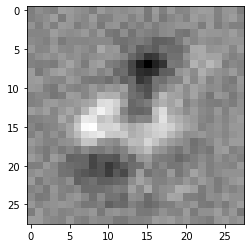

Epoch[33/100], loss: 0.437780, acc: 0.906000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


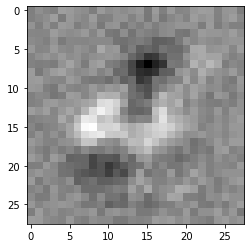

Epoch[34/100], loss: 0.432202, acc: 0.905000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


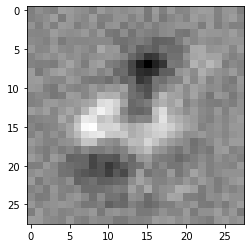

Epoch[35/100], loss: 0.426854, acc: 0.906000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


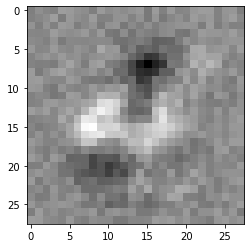

Epoch[36/100], loss: 0.421719, acc: 0.906000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


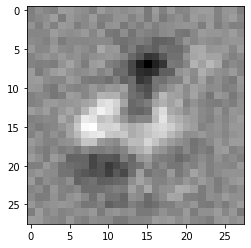

Epoch[37/100], loss: 0.416782, acc: 0.906000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


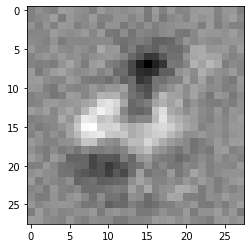

Epoch[38/100], loss: 0.412029, acc: 0.906000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


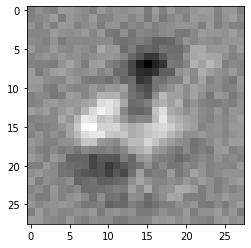

Epoch[39/100], loss: 0.407450, acc: 0.908000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


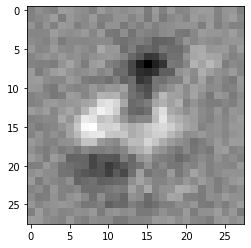

Epoch[40/100], loss: 0.403030, acc: 0.910000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


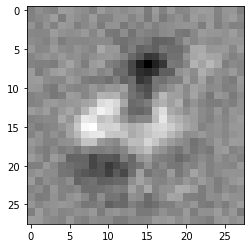

Epoch[41/100], loss: 0.398762, acc: 0.911000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


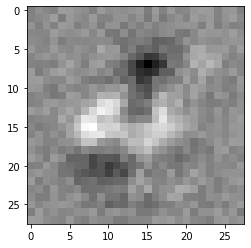

Epoch[42/100], loss: 0.394636, acc: 0.912000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


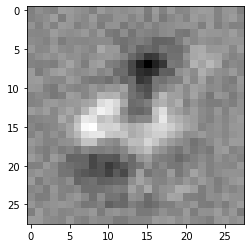

Epoch[43/100], loss: 0.390642, acc: 0.913000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


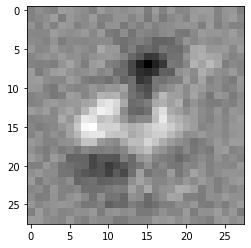

Epoch[44/100], loss: 0.386773, acc: 0.914000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


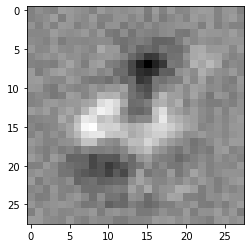

Epoch[45/100], loss: 0.383023, acc: 0.914000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


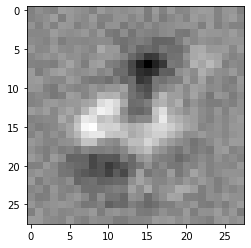

Epoch[46/100], loss: 0.379385, acc: 0.915000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


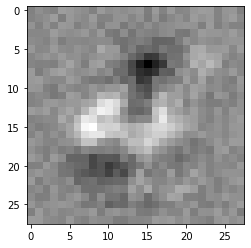

Epoch[47/100], loss: 0.375852, acc: 0.916000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


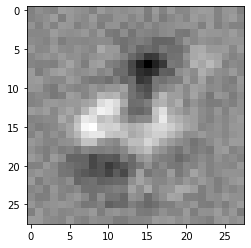

Epoch[48/100], loss: 0.372419, acc: 0.920000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


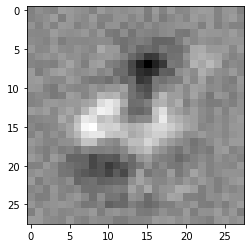

Epoch[49/100], loss: 0.369081, acc: 0.920000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


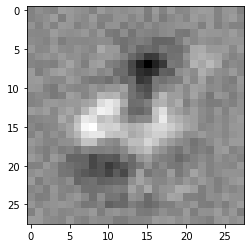

Epoch[50/100], loss: 0.365833, acc: 0.920000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


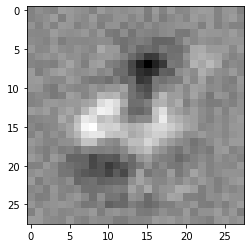

Epoch[51/100], loss: 0.362670, acc: 0.921000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


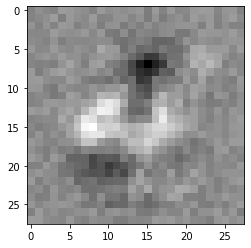

Epoch[52/100], loss: 0.359589, acc: 0.922000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


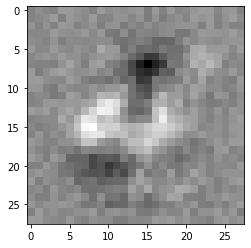

Epoch[53/100], loss: 0.356585, acc: 0.922000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


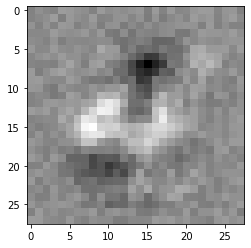

Epoch[54/100], loss: 0.353655, acc: 0.923000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


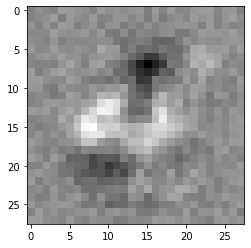

Epoch[55/100], loss: 0.350796, acc: 0.923000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


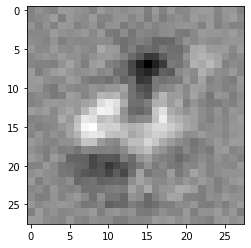

Epoch[56/100], loss: 0.348003, acc: 0.923000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


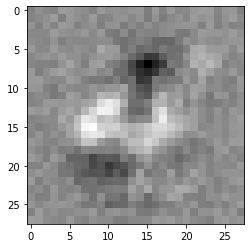

Epoch[57/100], loss: 0.345275, acc: 0.923000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


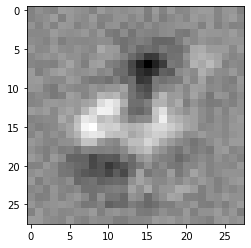

Epoch[58/100], loss: 0.342609, acc: 0.923000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


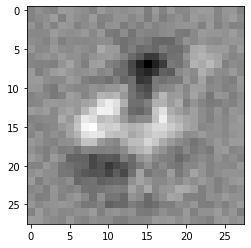

Epoch[59/100], loss: 0.340002, acc: 0.924000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


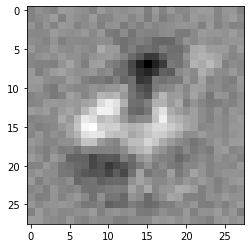

Epoch[60/100], loss: 0.337451, acc: 0.925000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


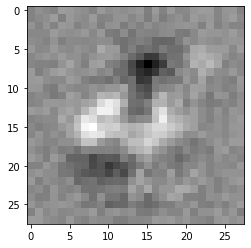

Epoch[61/100], loss: 0.334954, acc: 0.926000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


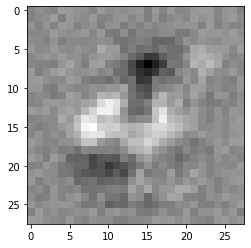

Epoch[62/100], loss: 0.332511, acc: 0.929000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


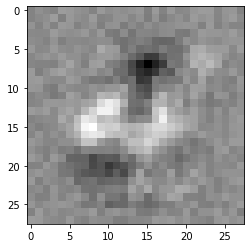

Epoch[63/100], loss: 0.330116, acc: 0.930000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


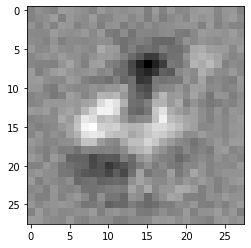

Epoch[64/100], loss: 0.327770, acc: 0.930000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


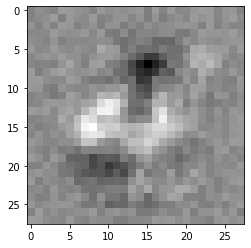

Epoch[65/100], loss: 0.325470, acc: 0.930000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


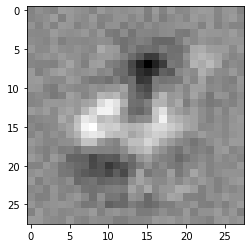

Epoch[66/100], loss: 0.323215, acc: 0.931000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


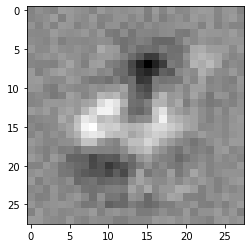

Epoch[67/100], loss: 0.321002, acc: 0.930000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


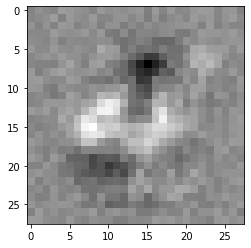

Epoch[68/100], loss: 0.318832, acc: 0.930000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


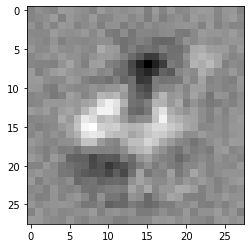

Epoch[69/100], loss: 0.316700, acc: 0.930000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


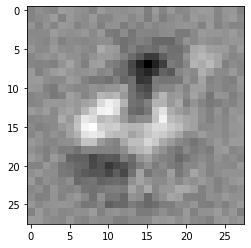

Epoch[70/100], loss: 0.314608, acc: 0.930000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


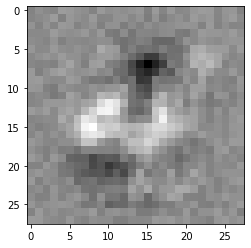

Epoch[71/100], loss: 0.312553, acc: 0.930000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


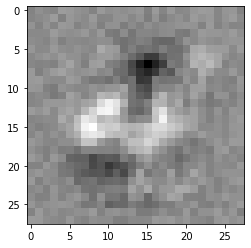

Epoch[72/100], loss: 0.310534, acc: 0.930000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


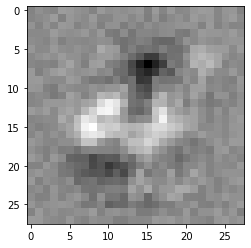

Epoch[73/100], loss: 0.308549, acc: 0.931000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


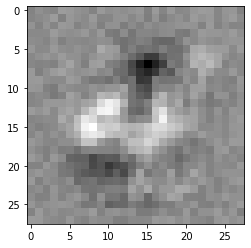

Epoch[74/100], loss: 0.306599, acc: 0.933000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


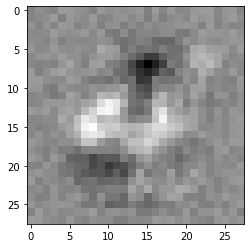

Epoch[75/100], loss: 0.304680, acc: 0.934000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


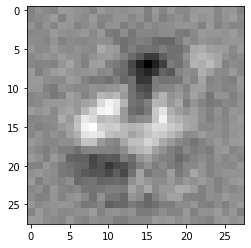

Epoch[76/100], loss: 0.302794, acc: 0.934000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


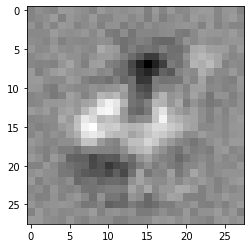

Epoch[77/100], loss: 0.300938, acc: 0.934000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


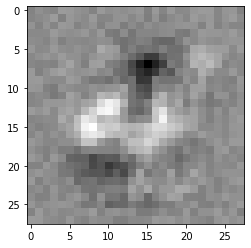

Epoch[78/100], loss: 0.299112, acc: 0.934000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


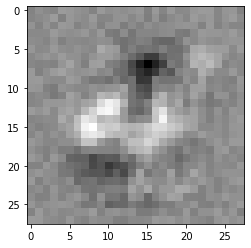

Epoch[79/100], loss: 0.297314, acc: 0.934000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


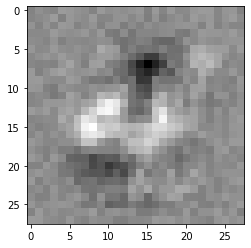

Epoch[80/100], loss: 0.295544, acc: 0.934000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


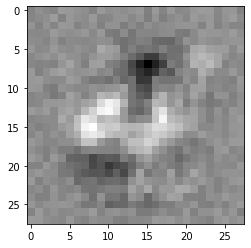

Epoch[81/100], loss: 0.293802, acc: 0.935000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


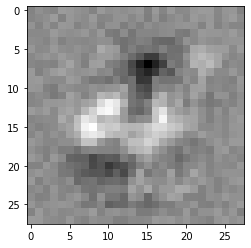

Epoch[82/100], loss: 0.292085, acc: 0.935000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


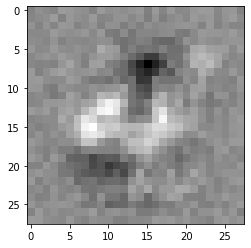

Epoch[83/100], loss: 0.290394, acc: 0.935000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


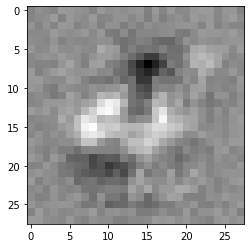

Epoch[84/100], loss: 0.288728, acc: 0.935000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


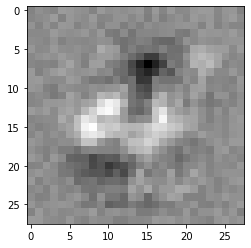

Epoch[85/100], loss: 0.287086, acc: 0.935000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


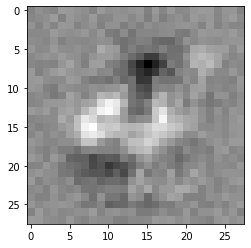

Epoch[86/100], loss: 0.285468, acc: 0.935000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


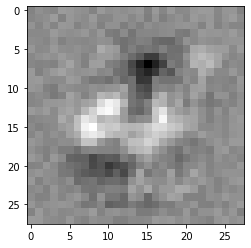

Epoch[87/100], loss: 0.283872, acc: 0.935000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


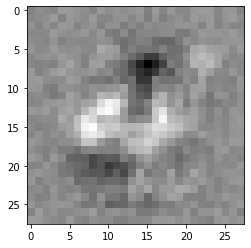

Epoch[88/100], loss: 0.282299, acc: 0.936000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


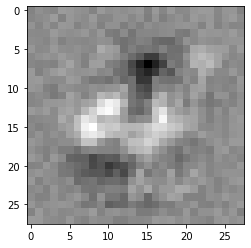

Epoch[89/100], loss: 0.280747, acc: 0.936000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


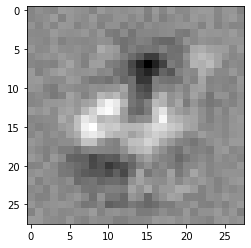

Epoch[90/100], loss: 0.279216, acc: 0.936000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


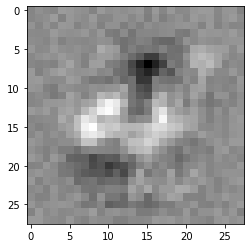

Epoch[91/100], loss: 0.277706, acc: 0.936000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


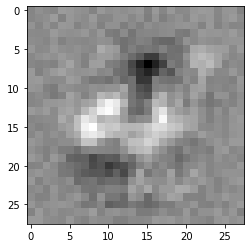

Epoch[92/100], loss: 0.276216, acc: 0.936000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


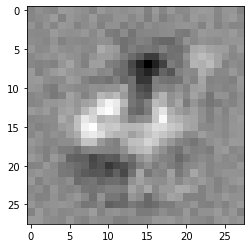

Epoch[93/100], loss: 0.274746, acc: 0.937000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


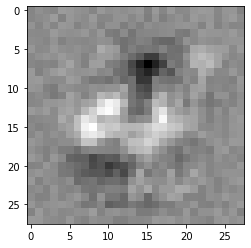

Epoch[94/100], loss: 0.273294, acc: 0.937000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


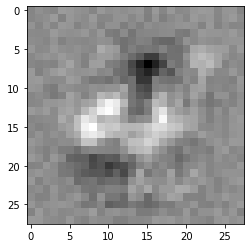

Epoch[95/100], loss: 0.271861, acc: 0.937000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


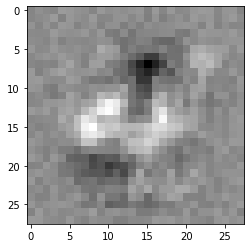

Epoch[96/100], loss: 0.270447, acc: 0.938000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


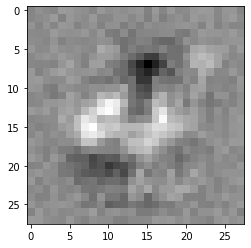

Epoch[97/100], loss: 0.269050, acc: 0.940000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


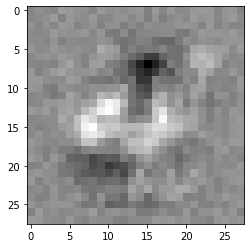

Epoch[98/100], loss: 0.267670, acc: 0.942000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


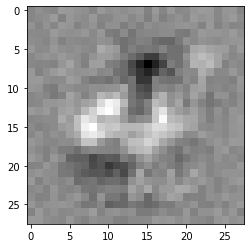

Epoch[99/100], loss: 0.266307, acc: 0.942000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


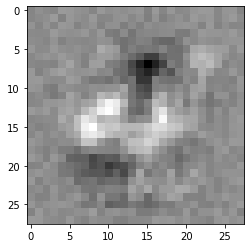

Epoch[100/100], loss: 0.264960, acc: 0.942000
weights: torch.Size([10, 784])
bias:    torch.Size([10])


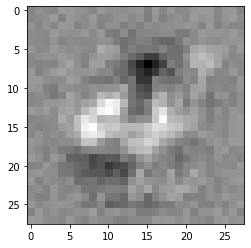

In [20]:
losses = []
import numpy

import numpy
zs = []

for i in range(epochs):
    # Transforma a entrada para uma dimensão
    inputs = Variable(x_train.view(-1, 28 * 28))
    # Predict da rede
    outputs = model(inputs)
    
    # z0 a z9
    zs.append(outputs[1].detach().numpy())

    # calcula a perda
    loss = criterion(outputs, Variable(y_train))

    # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    
    _, predicts = torch.max(outputs, 1)
    
    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()
    
    print('Epoch[{}/{}], loss: {:.6f}, acc: {:.6f}'
              .format(i+1, epochs, loss.data[0], accuracy))
    
    weights = model.state_dict()['weight']
    print('weights:', weights.shape)

    bias = model.state_dict()['bias']
    print('bias:   ', bias.shape)

    # Visualizando pesos da classe 3
    plt.imshow(weights[4, :].numpy().reshape((28,28)),cmap = 'gray')
    plt.show()

In [21]:
print('Final loss:', loss.item())

Final loss: 0.26496031880378723


### Visualizando gráfico de perda durante o treinamento

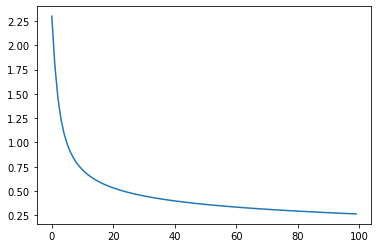

In [22]:
plt.plot(losses)

## Avaliação

### Acurácia tanto no conjunto de treinamento como no conjunto de testes

In [23]:
def predict(model, input_data):
    outputs = model(Variable(input_data))
    _, predicts = torch.max(outputs, 1)
    
    return predicts.data

y_pred = predict(model, x_train.view(-1, 28*28))
accuracy = (y_pred.numpy() == y_train.numpy()).mean()
print('Accuracy:', accuracy)

Accuracy: 0.942


### Matriz de confusão com dados de treinamento e teste

In [24]:
print('Matriz de confusão:')
pd.crosstab(y_pred.numpy(), y_train.numpy())

Matriz de confusão:


col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,96,0,1,0,0,0,1,0,0,2
1,0,110,1,0,0,0,2,2,1,0
2,0,1,91,1,0,1,0,1,2,1
3,0,0,0,88,0,2,0,0,0,0
4,0,0,1,0,102,2,1,2,0,3
5,0,2,0,1,0,82,0,0,2,1
6,1,0,1,1,2,2,90,0,0,0
7,0,1,1,1,0,0,0,111,0,3
8,0,2,2,0,0,1,0,0,82,0


## Visualizando a matriz de pesos treinados

Observe que a matriz de peso treinado para cada classe mostra a importância dos pesos associados aos caracteres de cada classe.

weights: torch.Size([10, 784])
bias:    torch.Size([10])


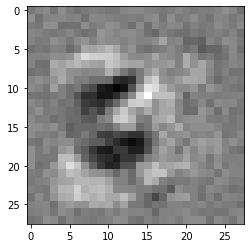

In [25]:
weights = model.state_dict()['weight']
print('weights:', weights.shape)

bias = model.state_dict()['bias']
print('bias:   ', bias.shape)

# Visualizando pesos da classe 3
plt.imshow(weights[3, :].numpy().reshape((28,28)),cmap = 'gray')
plt.show()

### Visualizando os pesos de todas as classes

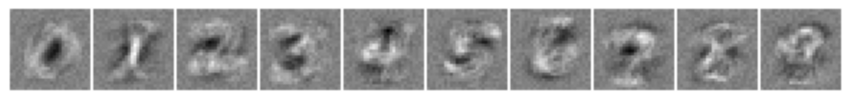

In [26]:
# cria um grid com as imagens
grid = torchvision.utils.make_grid(weights.view(-1, 1, 28, 28), normalize=True, pad_value=1.0, padding=1, nrow=10)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off');

### Diagrama da regressão softmax com visualização dos pesos W

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoSoftmaxArgmaxNMIST.png)

# Atividades

## Exercícios

- 1) Na configuração da figura acima, mostre os valores de z0 até z9, os valores das probabilidades y_hat, após o softmax, quando a rede recebe como entrada a nona amostra que contém o manuscrito do dígito '4':

- 2) Insira código no laço do treinamento para que no final de cada época, 
     seja impresso: o número da época e a perda e a acurácia

- 3) Insira código no laço do treinamento para visualização dos valores dos gradientes referentes à classe do dígito 4, no final de cada época.

## Perguntas

1. Qual é o shape da matriz de entrada na rede?
2. Qual é o shape da saída da rede?
3. Qual é o número total de parâmetros da rede, incluindo o bias?

# Aprendizados


1. Os atributos são os pixels rasterizados (28x28) para entrada na rede neural
2. Formato de imagem pode ser canal primeiro ou canal último (c,H,W) ou (H,W,c) respectivamente. O PyTorch utiliza formato (amostras, c, H, W). O matplotlib imshow utiliza formato (H,W,c) ou (H,W)
3. Este exemplo permite uma interpretação visual dos pesos (parâmetros treinados)